## 프로젝트 - Movielens 영화 SBR

`Movielens 1M Dataset`을 기반으로, Session based Recommendation 시스템을 제작해본다.

In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


```
1) 데이터 확인
$ ls -l ~/data

2) 프로젝트 폴더 생성
$ mkdir -p ~/aiffel/yoochoose

3) 프로젝트 폴더로 데이터 폴더 링크 연결
$ ln -s ~/data/* ~/aiffel/yoochoose/data
```

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [5]:
# 추천시스템 구축 시 가장 먼저 확인 해볼것은 유저수(세션수)와 아이템 수이다.
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [6]:
# 3점 이상만 남깁니다.
data = data[data['Rating']>=3]

data['UserId'].nunique(), data['ItemId'].nunique()

(6039, 3628)

In [7]:
# 각 세션이 몇 개의 클릭 데이터를 갖는지 확인해보기
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [8]:
session_length.median(), session_length.mean()

(81.0, 138.51266766020865)

In [9]:
session_length.min(), session_length.max()

(1, 1968)

In [10]:
session_length.quantile(0.95)

452.0

In [11]:
# 세션 길이가 1968인 데이터가 궁금해서 세부 정보를 확인해보았다.
long_session = session_length[session_length==1968].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697055,4169,3207,3,2002-06-15 20:23:26
695958,4169,3413,3,2002-06-15 20:33:11
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00


2000-08-03 20:09:52 -> 2002-06-15 21:25:37까지 약 2년간 클릭을 한 모습을 볼 수 있었다.


In [12]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_95 = length_percent_cumsum[length_percent_cumsum < 0.95]

length_percent_cumsum_95

1      0.000166
7      0.000331
9      0.000994
10     0.001159
11     0.001987
         ...   
445    0.948501
447    0.948833
448    0.949164
449    0.949661
451    0.949826
Length: 433, dtype: float64

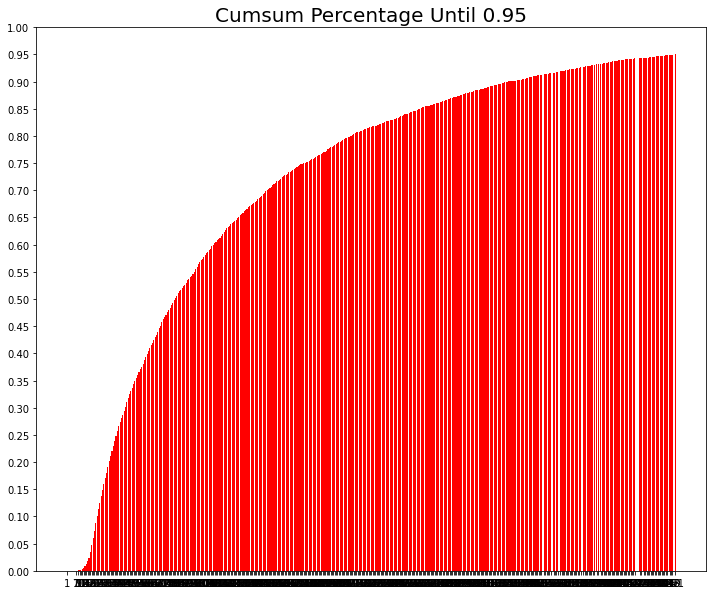

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_95.index,
        height=length_percent_cumsum_95, color='red')
plt.xticks(length_percent_cumsum_95.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.95', size=20)
plt.show()

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [15]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [17]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [18]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [19]:
data = data.sort_values(by=['Time'])  # data를 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-25 23:05:32
999873,6040,593,5,2000-04-25 23:05:54
1000153,6040,2384,4,2000-04-25 23:05:54
1000192,6040,2019,5,2000-04-25 23:06:17
1000007,6040,1961,4,2000-04-25 23:06:17
...,...,...,...,...
825526,4958,3489,4,2003-02-28 17:45:20
825438,4958,1407,5,2003-02-28 17:47:23
825731,4958,2634,3,2003-02-28 17:49:08
825724,4958,3264,4,2003-02-28 17:49:08


In [20]:
tr, test = split_by_date(data, n_days=110)
tr, val = split_by_date(tr, n_days=110)

In [21]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [22]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 715615
	 Sessions: 5680
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-07-19 21:17:30

* valid Set Stats Info
	 Events: 29289
	 Sessions: 98
	 Items: 2730
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2002-11-07 22:54:07

* test Set Stats Info
	 Events: 90885
	 Sessions: 260
	 Items: 3178
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



In [23]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [24]:
# 데이터 준비는 마쳤다. 데이터를 저장하고 data pipeline을 구축하는 단계로 넘어간다.
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Data Pipeline

In [25]:
# 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값ㅇ르 갖는 클래스 생성
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [26]:
# click_offsets 변수는 각 세션이 시작된 인덱스를 담고있다.
# session_idx 변수는 각 세션을 인덱싱한 np.array이다.
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000192,6040,2019,5,2000-04-25 23:06:17,3
1000007,6040,1961,4,2000-04-25 23:06:17,4
999980,6040,3505,4,2000-04-25 23:07:36,5
999967,6040,3111,5,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999877,6040,1419,3,2000-04-25 23:07:36,8
999868,6040,573,4,2000-04-25 23:07:36,9


In [27]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 715220, 715339, 715615], dtype=int32)

In [28]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5677, 5678, 5679])

In [29]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [30]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000192,6040,2019,5,2000-04-25 23:06:17,3
1000007,6040,1961,4,2000-04-25 23:06:17,4
999980,6040,3505,4,2000-04-25 23:07:36,5
999967,6040,3111,5,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999877,6040,1419,3,2000-04-25 23:07:36,8
999868,6040,573,4,2000-04-25 23:07:36,9


In [31]:
iter_ex = iter(tr_data_loader)

In [32]:
# 이번 셀을 반복실행하면 next가 계속 다음 데이터를 만든다.
# input, output, mask의 감을 찾아본다.
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53   3 193]
Label Item Idx are :       [  1  54  14 165]
Previous Masked Input Idx are []


## Modeling

In [33]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [35]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [36]:
# 하이퍼 파라미터를 class 형식으로 관리한다.
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

# args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [37]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [38]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [87]:
# 학습된 모델을 불러옵니다.
# args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
# model = create_model(args)
# train_model(model, args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.48it/s]


	 - Recall@20 epoch 1: 0.175110
	 - MRR@20    epoch 1: 0.039824



Evaluation:  56%|█████▌    | 256/456 [01:11<00:56,  3.56it/s]


	 - Recall@20 epoch 2: 0.224548
	 - MRR@20    epoch 2: 0.051342



Evaluation:  56%|█████▌    | 256/456 [01:10<00:55,  3.62it/s]

	 - Recall@20 epoch 3: 0.238770
	 - MRR@20    epoch 3: 0.055113



1차 시도는 epoch가 너무 낮기 때문에 조금 많이 늘려주도록 하겠다. <br/>
그동안 나는 산책을... 총총

In [ ]:
# 학습된 모델을 불러옵니다.
# args1 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
# model1 = create_model(args1)
# train_model(model1, args1)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout_3 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.48it/s]


	 - Recall@20 epoch 1: 0.171631
	 - MRR@20    epoch 1: 0.038228



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.60it/s]


	 - Recall@20 epoch 2: 0.222717
	 - MRR@20    epoch 2: 0.052497



Evaluation:  56%|█████▌    | 256/456 [01:10<00:55,  3.63it/s]


	 - Recall@20 epoch 3: 0.236267
	 - MRR@20    epoch 3: 0.056125



Evaluation:  56%|█████▌    | 256/456 [01:10<00:54,  3.64it/s]


	 - Recall@20 epoch 4: 0.243408
	 - MRR@20    epoch 4: 0.058484



Evaluation:  56%|█████▌    | 256/456 [01:10<00:54,  3.64it/s]


	 - Recall@20 epoch 5: 0.244385
	 - MRR@20    epoch 5: 0.060423



Evaluation:  56%|█████▌    | 256/456 [01:10<00:55,  3.64it/s]


	 - Recall@20 epoch 6: 0.245605
	 - MRR@20    epoch 6: 0.061406



Evaluation:  56%|█████▌    | 256/456 [01:10<00:54,  3.65it/s]


	 - Recall@20 epoch 7: 0.245850
	 - MRR@20    epoch 7: 0.062175



Evaluation:  56%|█████▌    | 256/456 [01:10<00:54,  3.64it/s]


	 - Recall@20 epoch 8: 0.245789
	 - MRR@20    epoch 8: 0.062858



Evaluation:  56%|█████▌    | 256/456 [01:10<00:54,  3.65it/s]


	 - Recall@20 epoch 9: 0.245178
	 - MRR@20    epoch 9: 0.062550



Evaluation:  56%|█████▌    | 256/456 [01:10<00:55,  3.62it/s]


	 - Recall@20 epoch 10: 0.243835
	 - MRR@20    epoch 10: 0.062158



Evaluation:  56%|█████▌    | 256/456 [01:10<00:55,  3.63it/s]


	 - Recall@20 epoch 11: 0.243164
	 - MRR@20    epoch 11: 0.061863



Evaluation:  56%|█████▌    | 256/456 [01:10<00:54,  3.64it/s]


	 - Recall@20 epoch 12: 0.242676
	 - MRR@20    epoch 12: 0.061630



Evaluation:  56%|█████▌    | 256/456 [01:10<00:55,  3.62it/s]


	 - Recall@20 epoch 13: 0.242554
	 - MRR@20    epoch 13: 0.060901



Train:  32%|███▏      | 3502/11092 [00:38<01:23, 91.25it/s, accuracy=0.0156, train_loss=6.07]

In [39]:
# # 학습된 모델을 불러옵니다.
# args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.2, lr=0.001, epochs=3, k=20)
# model = create_model(args)
# train_model(model, args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1022700   
_________________________________________________________________
dropout (Dropout)            (64, 100)                 0         
_________________________________________________________________
dense (Dense)                (64, 3307)                334007    
Total params: 1,356,707
Trainable params: 1,356,707
Non-trainable params: 0
_________________________________________________________________


Evaluation:  56%|█████▌    | 256/456 [01:14<00:57,  3.45it/s]


	 - Recall@20 epoch 1: 0.200867
	 - MRR@20    epoch 1: 0.047567



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.58it/s]


	 - Recall@20 epoch 2: 0.236328
	 - MRR@20    epoch 2: 0.056451



Evaluation:  56%|█████▌    | 256/456 [01:11<00:56,  3.57it/s]

	 - Recall@20 epoch 3: 0.242920
	 - MRR@20    epoch 3: 0.060077



In [40]:
# 학습된 모델을 불러옵니다.
args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.2, lr=0.01, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1022700   
_________________________________________________________________
dropout_1 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_1 (Dense)              (64, 3307)                334007    
Total params: 1,356,707
Trainable params: 1,356,707
Non-trainable params: 0
_________________________________________________________________


Evaluation:  56%|█████▌    | 256/456 [01:14<00:57,  3.46it/s]


	 - Recall@20 epoch 1: 0.216187
	 - MRR@20    epoch 1: 0.051962



Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.50it/s]


	 - Recall@20 epoch 2: 0.213318
	 - MRR@20    epoch 2: 0.051984



Evaluation:  56%|█████▌    | 256/456 [01:12<00:56,  3.52it/s]


	 - Recall@20 epoch 3: 0.212341
	 - MRR@20    epoch 3: 0.051664



Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.50it/s]


	 - Recall@20 epoch 4: 0.206299
	 - MRR@20    epoch 4: 0.048565



Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.51it/s]

	 - Recall@20 epoch 5: 0.211426
	 - MRR@20    epoch 5: 0.049374



In [41]:
# 학습된 모델을 불러옵니다.
args = Args(tr, val, test, batch_size=64, hsz=200, drop_rate=0.2, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 200), (64, 200)]    2105400   
_________________________________________________________________
dropout_2 (Dropout)          (64, 200)                 0         
_________________________________________________________________
dense_2 (Dense)              (64, 3307)                664707    
Total params: 2,770,107
Trainable params: 2,770,107
Non-trainable params: 0
_________________________________________________________________


Evaluation:  56%|█████▌    | 256/456 [01:12<00:56,  3.54it/s]


	 - Recall@20 epoch 1: 0.224182
	 - MRR@20    epoch 1: 0.052758



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.60it/s]


	 - Recall@20 epoch 2: 0.244568
	 - MRR@20    epoch 2: 0.060784



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.60it/s]


	 - Recall@20 epoch 3: 0.248901
	 - MRR@20    epoch 3: 0.063433



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.58it/s]


	 - Recall@20 epoch 4: 0.249023
	 - MRR@20    epoch 4: 0.064182



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.58it/s]

	 - Recall@20 epoch 5: 0.245544
	 - MRR@20    epoch 5: 0.061967



In [42]:
# 학습된 모델을 불러옵니다.
args = Args(tr, val, test, batch_size=32, hsz=200, drop_rate=0.2, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 200), (32, 200)]    2105400   
_________________________________________________________________
dropout_3 (Dropout)          (32, 200)                 0         
_________________________________________________________________
dense_3 (Dense)              (32, 3307)                664707    
Total params: 2,770,107
Trainable params: 2,770,107
Non-trainable params: 0
_________________________________________________________________


Evaluation:  79%|███████▊  | 716/912 [01:51<00:30,  6.43it/s]


	 - Recall@20 epoch 1: 0.224948
	 - MRR@20    epoch 1: 0.053603



Evaluation:  79%|███████▊  | 716/912 [01:50<00:30,  6.51it/s]


	 - Recall@20 epoch 2: 0.245854
	 - MRR@20    epoch 2: 0.062227



Evaluation:  79%|███████▊  | 716/912 [01:49<00:30,  6.53it/s]


	 - Recall@20 epoch 3: 0.248254
	 - MRR@20    epoch 3: 0.063351



Evaluation:  79%|███████▊  | 716/912 [01:49<00:29,  6.54it/s]


	 - Recall@20 epoch 4: 0.242449
	 - MRR@20    epoch 4: 0.062349



Evaluation:  79%|███████▊  | 716/912 [01:51<00:30,  6.45it/s]

	 - Recall@20 epoch 5: 0.240442
	 - MRR@20    epoch 5: 0.060847



In [43]:
# 학습된 모델을 불러옵니다.
args = Args(tr, val, test, batch_size=32, hsz=500, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(32, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 500), (32, 500)]    5713500   
_________________________________________________________________
dropout_4 (Dropout)          (32, 500)                 0         
_________________________________________________________________
dense_4 (Dense)              (32, 3307)                1656807   
Total params: 7,370,307
Trainable params: 7,370,307
Non-trainable params: 0
_________________________________________________________________


Evaluation:  79%|███████▊  | 716/912 [01:51<00:30,  6.42it/s]


	 - Recall@20 epoch 1: 0.232018
	 - MRR@20    epoch 1: 0.058360



Evaluation:  79%|███████▊  | 716/912 [01:51<00:30,  6.43it/s]


	 - Recall@20 epoch 2: 0.233720
	 - MRR@20    epoch 2: 0.059574



Evaluation:  79%|███████▊  | 716/912 [01:52<00:30,  6.39it/s]


	 - Recall@20 epoch 3: 0.225035
	 - MRR@20    epoch 3: 0.056844



Evaluation:  79%|███████▊  | 716/912 [01:52<00:30,  6.37it/s]


	 - Recall@20 epoch 4: 0.210152
	 - MRR@20    epoch 4: 0.052717



Evaluation:  79%|███████▊  | 716/912 [01:52<00:30,  6.34it/s]

	 - Recall@20 epoch 5: 0.199633
	 - MRR@20    epoch 5: 0.051634



In [44]:
# 학습된 모델을 불러옵니다.
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.3, lr=0.1, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout_5 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_5 (Dense)              (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


Evaluation:  56%|█████▌    | 256/456 [01:18<01:01,  3.26it/s]


	 - Recall@20 epoch 1: 0.032532
	 - MRR@20    epoch 1: 0.005250



Evaluation:  56%|█████▌    | 256/456 [01:18<01:01,  3.25it/s]


	 - Recall@20 epoch 2: 0.030273
	 - MRR@20    epoch 2: 0.004700



Evaluation:  56%|█████▌    | 256/456 [01:18<01:01,  3.27it/s]


	 - Recall@20 epoch 3: 0.032227
	 - MRR@20    epoch 3: 0.004929



Evaluation:  56%|█████▌    | 256/456 [01:18<01:01,  3.26it/s]


	 - Recall@20 epoch 4: 0.032654
	 - MRR@20    epoch 4: 0.005165



Evaluation:  56%|█████▌    | 256/456 [01:18<01:01,  3.26it/s]

	 - Recall@20 epoch 5: 0.028198
	 - MRR@20    epoch 5: 0.004787



In [45]:
# 학습된 모델을 불러옵니다.
args = Args(tr, val, test, batch_size=64, hsz=500, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 500), (64, 500)]    5713500   
_________________________________________________________________
dropout_6 (Dropout)          (64, 500)                 0         
_________________________________________________________________
dense_6 (Dense)              (64, 3307)                1656807   
Total params: 7,370,307
Trainable params: 7,370,307
Non-trainable params: 0
_________________________________________________________________


Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.57it/s]


	 - Recall@20 epoch 1: 0.238892
	 - MRR@20    epoch 1: 0.058537



Evaluation:  56%|█████▌    | 256/456 [01:10<00:55,  3.61it/s]


	 - Recall@20 epoch 2: 0.245361
	 - MRR@20    epoch 2: 0.063897



Evaluation:  56%|█████▌    | 256/456 [01:10<00:55,  3.62it/s]


	 - Recall@20 epoch 3: 0.238281
	 - MRR@20    epoch 3: 0.062566



Evaluation:  56%|█████▌    | 256/456 [01:11<00:56,  3.56it/s]


	 - Recall@20 epoch 4: 0.224609
	 - MRR@20    epoch 4: 0.058086



Evaluation:  56%|█████▌    | 256/456 [01:12<00:56,  3.54it/s]

	 - Recall@20 epoch 5: 0.215271
	 - MRR@20    epoch 5: 0.055617



In [46]:
# 학습된 모델을 불러옵니다.
args = Args(tr, val, test, batch_size=64, hsz=500, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 500), (64, 500)]    5713500   
_________________________________________________________________
dropout_7 (Dropout)          (64, 500)                 0         
_________________________________________________________________
dense_7 (Dense)              (64, 3307)                1656807   
Total params: 7,370,307
Trainable params: 7,370,307
Non-trainable params: 0
_________________________________________________________________


Evaluation:  56%|█████▌    | 256/456 [01:11<00:56,  3.57it/s]


	 - Recall@20 epoch 1: 0.236816
	 - MRR@20    epoch 1: 0.058067



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.60it/s]


	 - Recall@20 epoch 2: 0.245850
	 - MRR@20    epoch 2: 0.063955



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.58it/s]


	 - Recall@20 epoch 3: 0.239563
	 - MRR@20    epoch 3: 0.061776



Evaluation:  56%|█████▌    | 256/456 [01:12<00:56,  3.54it/s]


	 - Recall@20 epoch 4: 0.221802
	 - MRR@20    epoch 4: 0.056954



Evaluation:  56%|█████▌    | 256/456 [01:12<00:56,  3.53it/s]


	 - Recall@20 epoch 5: 0.212463
	 - MRR@20    epoch 5: 0.054104



Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.51it/s]


	 - Recall@20 epoch 6: 0.204224
	 - MRR@20    epoch 6: 0.053431



Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.50it/s]


	 - Recall@20 epoch 7: 0.196594
	 - MRR@20    epoch 7: 0.050628



Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.48it/s]


	 - Recall@20 epoch 8: 0.190857
	 - MRR@20    epoch 8: 0.048943



Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.50it/s]


	 - Recall@20 epoch 9: 0.189331
	 - MRR@20    epoch 9: 0.049097



Evaluation:  56%|█████▌    | 256/456 [01:14<00:57,  3.45it/s]


	 - Recall@20 epoch 10: 0.186768
	 - MRR@20    epoch 10: 0.047779



Evaluation:  56%|█████▌    | 256/456 [01:14<00:58,  3.43it/s]


	 - Recall@20 epoch 11: 0.181519
	 - MRR@20    epoch 11: 0.046572



Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.48it/s]


	 - Recall@20 epoch 12: 0.178894
	 - MRR@20    epoch 12: 0.045669



Evaluation:  56%|█████▌    | 256/456 [01:14<00:57,  3.46it/s]


	 - Recall@20 epoch 13: 0.176331
	 - MRR@20    epoch 13: 0.046330



Evaluation:  56%|█████▌    | 256/456 [01:14<00:57,  3.46it/s]


	 - Recall@20 epoch 14: 0.176636
	 - MRR@20    epoch 14: 0.044941



Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.48it/s]


	 - Recall@20 epoch 15: 0.177368
	 - MRR@20    epoch 15: 0.044014



Evaluation:  56%|█████▌    | 256/456 [01:14<00:58,  3.44it/s]


	 - Recall@20 epoch 16: 0.172974
	 - MRR@20    epoch 16: 0.043171



Evaluation:  56%|█████▌    | 256/456 [01:14<00:58,  3.44it/s]


	 - Recall@20 epoch 17: 0.173584
	 - MRR@20    epoch 17: 0.042720



Evaluation:  56%|█████▌    | 256/456 [01:14<00:58,  3.43it/s]


	 - Recall@20 epoch 18: 0.173340
	 - MRR@20    epoch 18: 0.043581



Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.47it/s]


	 - Recall@20 epoch 19: 0.172852
	 - MRR@20    epoch 19: 0.042945



Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.47it/s]

	 - Recall@20 epoch 20: 0.173279
	 - MRR@20    epoch 20: 0.043581



In [47]:
# 학습된 모델을 불러옵니다.
args = Args(tr, val, test, batch_size=64, hsz=700, drop_rate=0.5, lr=0.001, epochs=8, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 700), (64, 700)]    8418900   
_________________________________________________________________
dropout_8 (Dropout)          (64, 700)                 0         
_________________________________________________________________
dense_8 (Dense)              (64, 3307)                2318207   
Total params: 10,737,107
Trainable params: 10,737,107
Non-trainable params: 0
_________________________________________________________________


Evaluation:  56%|█████▌    | 256/456 [01:12<00:56,  3.55it/s]


	 - Recall@20 epoch 1: 0.233154
	 - MRR@20    epoch 1: 0.058438



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.59it/s]


	 - Recall@20 epoch 2: 0.256165
	 - MRR@20    epoch 2: 0.065824



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.58it/s]


	 - Recall@20 epoch 3: 0.256287
	 - MRR@20    epoch 3: 0.067545



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.59it/s]


	 - Recall@20 epoch 4: 0.252747
	 - MRR@20    epoch 4: 0.066605



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.59it/s]


	 - Recall@20 epoch 5: 0.243225
	 - MRR@20    epoch 5: 0.065562



Evaluation:  56%|█████▌    | 256/456 [01:11<00:55,  3.58it/s]


	 - Recall@20 epoch 6: 0.240540
	 - MRR@20    epoch 6: 0.064614



Evaluation:  56%|█████▌    | 256/456 [01:11<00:56,  3.57it/s]


	 - Recall@20 epoch 7: 0.235291
	 - MRR@20    epoch 7: 0.062119



Evaluation:  56%|█████▌    | 256/456 [01:13<00:57,  3.46it/s]

	 - Recall@20 epoch 8: 0.229187
	 - MRR@20    epoch 8: 0.062009



회고 : 여러가지 파라미터 값들을 수정해보았지만 눈에 띄일만한 결과는 도출해내지 못했다. 처음에는 계속 이상한 오류가 떠서 원인이 뭔가 찾으면서 고생했었는데 batch_size 값 때문인 것을 알게되었고 64이하의 숫자들로 구성했을 때는 문제없이 학습을 했었다. 또 batch_size를 줄일수록 Evaluation의 학습양이 늘어나는 것을 발견했는데 그 이유에 대해서는 잘 모르겠다. 또 하이퍼파라미터를 다양하게 수정해보았으나 학습률은 크게 성장하지 못했다. 하이퍼파라미터의 문제는 아닌것으로 보여진다.